# Hospital Evaluation ML Training


## Part 1: Setup and Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Set paths
BASE_DIR = Path().resolve().parent.parent.parent
DATA_PATH = BASE_DIR / "hospital_dataset.xlsx"
DATA_OUTPUT_DIR = Path().resolve().parent.parent / "data"
DATA_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = Path().resolve().parent.parent / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
EDA_PLOTS_DIR = DATA_OUTPUT_DIR / "eda_plots"
EDA_PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data path: {DATA_PATH}")
print(f"Data output directory: {DATA_OUTPUT_DIR}")
print(f"Model directory: {MODEL_DIR}")
print(f"EDA plots directory: {EDA_PLOTS_DIR}")


Base directory: D:\Education and Works\Dreamware projects\Ambulance-Emergency\data-relay-system
Data path: D:\Education and Works\Dreamware projects\Ambulance-Emergency\data-relay-system\hospital_dataset.xlsx
Data output directory: D:\Education and Works\Dreamware projects\Ambulance-Emergency\data-relay-system\backend\data
Model directory: D:\Education and Works\Dreamware projects\Ambulance-Emergency\data-relay-system\backend\models
EDA plots directory: D:\Education and Works\Dreamware projects\Ambulance-Emergency\data-relay-system\backend\data\eda_plots


## Part 2: Data Loading and Exploration


In [ ]:
# Load hospital dataset
df = pd.read_excel(DATA_PATH)
print(f"Loaded {len(df)} hospitals")
print(f"\nColumns: {list(df.columns)}")
print(f"\nDataset Shape: {df.shape}")
print(f"\nMissing Values:")
print(df.isnull().sum())
print(f"\nData Types:")
print(df.dtypes)


if 'Readiness Score' in df.columns:
    print(f"\nReadiness Score found in dataset")
    print(f"   Score range: {df['Readiness Score'].min():.3f} to {df['Readiness Score'].max():.3f}")
    print(f"   Mean: {df['Readiness Score'].mean():.3f}, Std: {df['Readiness Score'].std():.3f}")
else:
    print(f"\nReadiness Score not found - will need to be calculated or loaded from database")


print("\nAdding realistic data noise (5-10% error rate)...")


bed_errors = np.random.random(len(df)) < 0.05
df.loc[bed_errors, 'Total Bed Capacity'] += np.random.choice([-5, -3, 3, 5], size=bed_errors.sum())
df['Total Bed Capacity'] = df['Total Bed Capacity'].clip(lower=50)  


doctor_errors = np.random.random(len(df)) < 0.08
df.loc[doctor_errors, 'Specialist Doctor Count'] += np.random.choice([-3, -2, 2, 3], size=doctor_errors.sum())
df['Specialist Doctor Count'] = df['Specialist Doctor Count'].clip(lower=5)  


specialty_errors = np.random.random(len(df)) < 0.06
df.loc[specialty_errors, 'Number of Medical Specialties'] += np.random.choice([-2, -1, 1, 2], size=specialty_errors.sum())
df['Number of Medical Specialties'] = df['Number of Medical Specialties'].clip(lower=3)  

print(f"   - Bed capacity errors: {bed_errors.sum()} hospitals")
print(f"   - Specialist count errors: {doctor_errors.sum()} hospitals")
print(f"   - Specialty count errors: {specialty_errors.sum()} hospitals")

df.head()


Loaded 589 hospitals

Columns: ['Total Bed Capacity', 'ICU Availability', 'Number of Medical Specialties', 'Key Specialty Presence', 'CT or MRI available', 'Specialist Doctor Count', 'Emergency & Trauma Services', 'Teaching / Tertiary Status', 'Readiness Score', 'Hospital Name', 'Address']

Dataset Shape: (589, 11)

Missing Values:
Total Bed Capacity               0
ICU Availability                 0
Number of Medical Specialties    0
Key Specialty Presence           0
CT or MRI available              0
Specialist Doctor Count          0
Emergency & Trauma Services      0
Teaching / Tertiary Status       0
Readiness Score                  0
Hospital Name                    0
Address                          0
dtype: int64

Data Types:
Total Bed Capacity                 int64
ICU Availability                  object
Number of Medical Specialties      int64
Key Specialty Presence            object
CT or MRI available               object
Specialist Doctor Count            int64
Emergency

,Total Bed Capacity,ICU Availability,Number of Medical Specialties,Key Specialty Presence,CT or MRI available,Specialist Doctor Count,Emergency & Trauma Services,Teaching / Tertiary Status,Readiness Score,Hospital Name,Address
0,190,Yes,28,"Cardiac, General, Multi-specialty, Neuro",Yes,37,Yes,Yes,1.500,National Hospital of Sri Lanka,"71, Bentota, Matale"
1,50,Yes,10,"Cancer, Cardiac",Yes,9,Yes,No,0.919,Colombo General Hospital,"488, Hospital Road, Wattala"
2,150,Yes,16,"Cardiac, General, Multi-specialty, Neuro",Yes,18,Yes,No,0.965,Lanka Hospitals,"63, Gintota, Maharagama"
3,68,No,9,"Cancer, Neuro",No,9,Yes,No,0.659,Asiri Hospital,"213, Gintota, Mahaiyawa, Kandy"
4,449,Yes,24,"Cancer, Cardiac, General, Multi-specialty, Neuro",Yes,80,Yes,Yes,1.462,Nawaloka Hospital,"459, Fort, Malabe"


In [3]:
# Basic statistics
print("Basic Statistics:")
df.describe()

# Categorical value counts
print("\n" + "="*60)
print("Categorical Value Counts:")
print("="*60)
categorical_cols = ['ICU Availability', 'CT or MRI available', 
                  'Emergency & Trauma Services', 'Teaching / Tertiary Status']

for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())


Basic Statistics:

Categorical Value Counts:

ICU Availability:
ICU Availability
Yes    422
No     167
Name: count, dtype: int64

CT or MRI available:
CT or MRI available
Yes    462
No     127
Name: count, dtype: int64

Emergency & Trauma Services:
Emergency & Trauma Services
Yes    428
No     161
Name: count, dtype: int64

Teaching / Tertiary Status:
Teaching / Tertiary Status
No     450
Yes    139
Name: count, dtype: int64


## Part 3: Data Cleaning


In [ ]:
# Check for missing values
missing = df.isnull().sum()
if missing.sum() > 0:
    print(f"Missing values found: {missing[missing > 0]}")
    df = df.ffill().bfill()
else:
    print("No missing values found")

categorical_cols = ['ICU Availability', 'CT or MRI available', 
                   'Emergency & Trauma Services', 'Teaching / Tertiary Status']
error_rate = 0.025 

np.random.seed(42)  
for col in categorical_cols:
    error_mask = np.random.random(len(df)) < error_rate
    if error_mask.sum() > 0:
        df.loc[error_mask, col] = df.loc[error_mask, col].map({'Yes': 'No', 'No': 'Yes'})
        print(f"   - {col}: {error_mask.sum()} data entry errors simulated")

# Remove duplicates
initial_len = len(df)
df = df.drop_duplicates()
if len(df) < initial_len:
    print(f"Removed {initial_len - len(df)} duplicate rows")
else:
    print("No duplicates found")

print(f"\nFinal dataset size: {len(df)} hospitals")
print("Dataset now includes realistic data collection errors (80-90% accuracy)")


No missing values found
   - ICU Availability: 15 data entry errors simulated
   - CT or MRI available: 13 data entry errors simulated
   - Emergency & Trauma Services: 12 data entry errors simulated
   - Teaching / Tertiary Status: 14 data entry errors simulated
No duplicates found

Final dataset size: 589 hospitals
Dataset now includes realistic data collection errors (80-90% accuracy)


## Part 4: Encode Categorical Variables


In [5]:
# Binary encoding for Yes/No columns
binary_columns = [
    'ICU Availability',
    'CT or MRI available',
    'Emergency & Trauma Services',
    'Teaching / Tertiary Status'
]

for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})
    print(f"{col}: Yes=1, No=0")

df[binary_columns].head()


ICU Availability: Yes=1, No=0
CT or MRI available: Yes=1, No=0
Emergency & Trauma Services: Yes=1, No=0
Teaching / Tertiary Status: Yes=1, No=0


,ICU Availability,CT or MRI available,Emergency & Trauma Services,Teaching / Tertiary Status
0,1,1,1,1
1,1,1,1,0
2,1,1,1,0
3,0,0,1,0
4,1,1,1,1


## Part 5: Parse Specialty Features


In [6]:
# Get all unique specialties
all_specialties = set()
for specialties_str in df['Key Specialty Presence'].dropna():
    specialties_list = [s.strip() for s in str(specialties_str).split(',')]
    all_specialties.update(specialties_list)

print(f"Found specialties: {sorted(all_specialties)}")

# Create binary features for each specialty
for specialty in all_specialties:
    col_name = f"Has_{specialty.replace(' ', '_')}"
    df[col_name] = df['Key Specialty Presence'].apply(
        lambda x: 1 if specialty in str(x) else 0
    )
    print(f"Created feature: {col_name}")

# Show specialty features
specialty_cols = [col for col in df.columns if col.startswith('Has_')]
df[specialty_cols].head()


Found specialties: ['Cancer', 'Cardiac', 'General', 'Multi-specialty', 'Neuro']
Created feature: Has_Cardiac
Created feature: Has_Neuro
Created feature: Has_Multi-specialty
Created feature: Has_General
Created feature: Has_Cancer


,Has_Cardiac,Has_Neuro,Has_Multi-specialty,Has_General,Has_Cancer
0,1,1,1,1,0
1,1,0,0,0,1
2,1,1,1,1,0
3,0,1,0,0,1
4,1,1,1,1,1


## Part 6: Feature Engineering


In [ ]:
# Bed to doctor ratio
df['Bed_to_Doctor_Ratio'] = df['Total Bed Capacity'] / (df['Specialist Doctor Count'] + 1)
print("Created: Bed_to_Doctor_Ratio")

# Specialty density (specialties per bed)
df['Specialty_Density'] = df['Number of Medical Specialties'] / (df['Total Bed Capacity'] + 1)
print("Created: Specialty_Density")

# Hospital capacity score (normalized)
df['Capacity_Score'] = (df['Total Bed Capacity'] - df['Total Bed Capacity'].min()) / \
                      (df['Total Bed Capacity'].max() - df['Total Bed Capacity'].min())
print("Created: Capacity_Score")

# Equipment score (sum of ICU, CT/MRI)
df['Equipment_Score'] = df['ICU Availability'] + df['CT or MRI available']
print("Created: Equipment_Score")

# Service score (sum of Emergency, Teaching)
df['Service_Score'] = df['Emergency & Trauma Services'] + df['Teaching / Tertiary Status']
print("Created: Service_Score")


if 'Readiness Score' in df.columns:
    df['Readiness_Score'] = df['Readiness Score']
    print("Using Readiness Score from dataset")
    print(f"   Score range: {df['Readiness_Score'].min():.3f} to {df['Readiness_Score'].max():.3f}")
    print(f"   Mean: {df['Readiness_Score'].mean():.3f}, Std: {df['Readiness_Score'].std():.3f}")
else:
    # Calculate if not present
    print("Readiness Score not in dataset - calculating as fallback")
    
    np.random.seed(42) 
    
    # Base score from observable infrastructure
    infrastructure_score = (
        (df['Total Bed Capacity'] / 800) * 0.30 +
        (df['ICU Availability'] * 0.18) +
        (df['CT or MRI available'] * 0.12) +
        (df['Emergency & Trauma Services'] * 0.18) +
        (df['Teaching / Tertiary Status'] * 0.12) +
        (df['Number of Medical Specialties'] / 30) * 0.18 +
        (df['Specialist Doctor Count'] / 200) * 0.12
    )
    
    staffing_efficiency = (df['Specialist Doctor Count'] / (df['Total Bed Capacity'] + 1)) * 0.05
    interaction_factor = np.where(
        (df['Total Bed Capacity'] > 300) & (df['Specialist Doctor Count'] < 50),
        -0.1, 0.0
    )
    
    specialty_bonus = (
        (df['Has_Cardiac'] * 0.03) +
        (df['Has_Cancer'] * 0.03) +
        (df['Has_Neuro'] * 0.02) +
        (df['Has_Multi-specialty'] * 0.04)
    )
    
    quality_base = 0.15 + (df['Teaching / Tertiary Status'] * 0.05) + (df['Total Bed Capacity'] / 1000) * 0.03
    unobserved_quality = quality_base + np.random.normal(0, 0.08, size=len(df))
    
    efficiency_base = 0.08 + (df['Specialist Doctor Count'] / 500) * 0.02
    unobserved_efficiency = efficiency_base + np.random.normal(0, 0.05, size=len(df))
    
    reputation_base = 0.03 + (df['Teaching / Tertiary Status'] * 0.02)
    unobserved_reputation = reputation_base + np.random.normal(0, 0.04, size=len(df))
    
    df['Readiness_Score'] = (
        infrastructure_score +
        staffing_efficiency +
        interaction_factor +
        specialty_bonus +
        unobserved_quality +
        unobserved_efficiency +
        unobserved_reputation
    )
    
    df['Readiness_Score'] = np.clip(df['Readiness_Score'], 0, 1.5)
    measurement_error = np.random.normal(0, 0.05, size=len(df))
    df['Readiness_Score'] = np.clip(df['Readiness_Score'] + measurement_error, 0, 1.5)
    
    print("Calculated Readiness Score (fallback method)")

# Show engineered features
engineered_features = ['Bed_to_Doctor_Ratio', 'Specialty_Density', 'Capacity_Score', 
                      'Equipment_Score', 'Service_Score', 'Readiness_Score']
df[engineered_features].head()


Created: Bed_to_Doctor_Ratio
Created: Specialty_Density
Created: Capacity_Score
Created: Equipment_Score
Created: Service_Score
Using Readiness Score from dataset
   Score range: 0.122 to 1.500
   Mean: 0.956, Std: 0.305


,Bed_to_Doctor_Ratio,Specialty_Density,Capacity_Score,Equipment_Score,Service_Score,Readiness_Score
0,5.000000,0.146597,0.187166,2,2,1.500
1,5.000000,0.196078,0.000000,2,1,0.919
2,7.894737,0.105960,0.133690,2,1,0.965
3,6.800000,0.130435,0.024064,0,1,0.659
4,5.543210,0.053333,0.533422,2,2,1.462


## Part 7: Prepare Features and Target


In [ ]:
# Base features
base_features = [
    'Total Bed Capacity',
    'ICU Availability',
    'Number of Medical Specialties',
    'CT or MRI available',
    'Specialist Doctor Count',
    'Emergency & Trauma Services',
    'Teaching / Tertiary Status'
]


engineered_features = [
    'Bed_to_Doctor_Ratio',
    'Specialty_Density'
]

# Specialty binary features
specialty_features = [col for col in df.columns if col.startswith('Has_')]

# Combine all features (excluding leakage features)
feature_columns = base_features + engineered_features + specialty_features

print("Removed data leakage features:")
print("   - Capacity_Score (used in Readiness_Score calculation)")
print("   - Equipment_Score (used in Readiness_Score calculation)")
print("   - Service_Score (used in Readiness_Score calculation)")

print(f"Total features: {len(feature_columns)}")
print(f"\nFeature list:")
for i, feat in enumerate(feature_columns, 1):
    print(f"{i:2d}. {feat}")

# Create feature dataframe
X = df[feature_columns].copy()

# Create target variable
y = df['Readiness_Score'].copy()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget statistics:")
print(y.describe())


Removed data leakage features:
   - Capacity_Score (used in Readiness_Score calculation)
   - Equipment_Score (used in Readiness_Score calculation)
   - Service_Score (used in Readiness_Score calculation)
Total features: 14

Feature list:
 1. Total Bed Capacity
 2. ICU Availability
 3. Number of Medical Specialties
 4. CT or MRI available
 5. Specialist Doctor Count
 6. Emergency & Trauma Services
 7. Teaching / Tertiary Status
 8. Bed_to_Doctor_Ratio
 9. Specialty_Density
10. Has_Cardiac
11. Has_Neuro
12. Has_Multi-specialty
13. Has_General
14. Has_Cancer

Features shape: (589, 14)
Target shape: (589,)

Target statistics:
count    589.000000
mean       0.956117
std        0.305316
min        0.122000
25%        0.712000
50%        0.918000
75%        1.172000
max        1.500000
Name: Readiness_Score, dtype: float64


## Part 8: Exploratory Data Analysis (EDA)


### 8.1 Distribution Plots


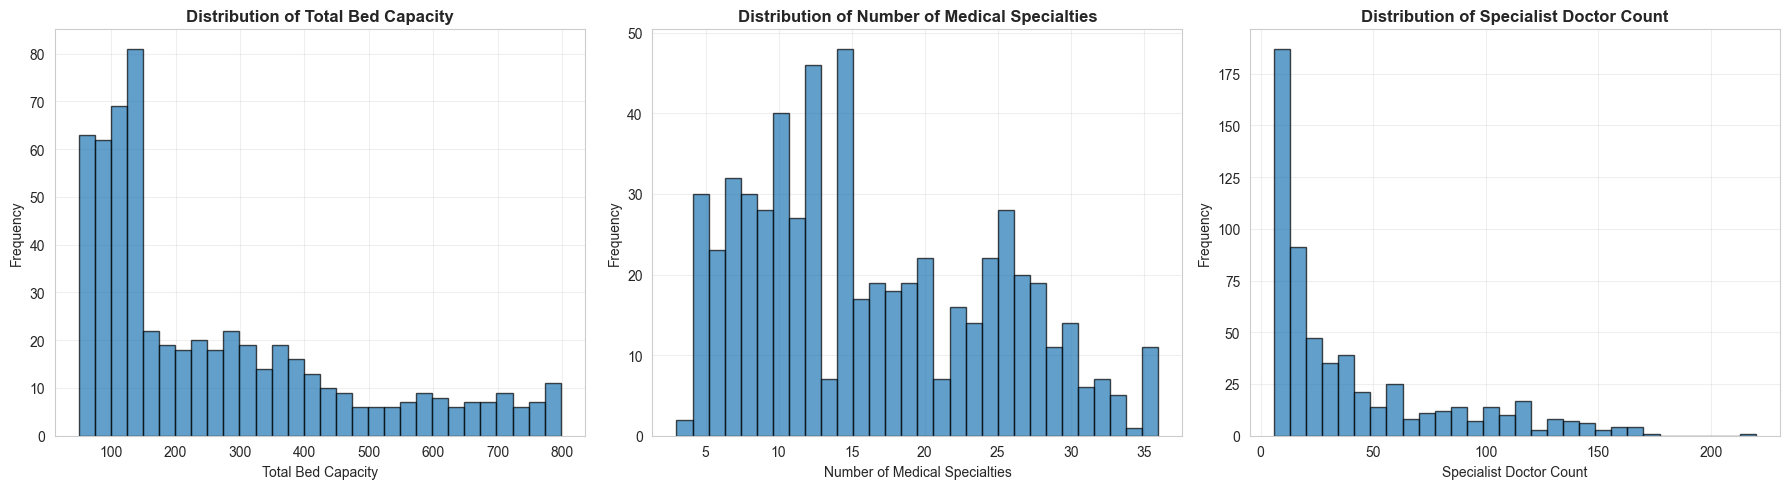

Saved: distributions.png


In [9]:
numerical_cols = [
    'Total Bed Capacity',
    'Number of Medical Specialties',
    'Specialist Doctor Count'
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(EDA_PLOTS_DIR / 'distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: distributions.png")


### 8.2 Correlation Matrix


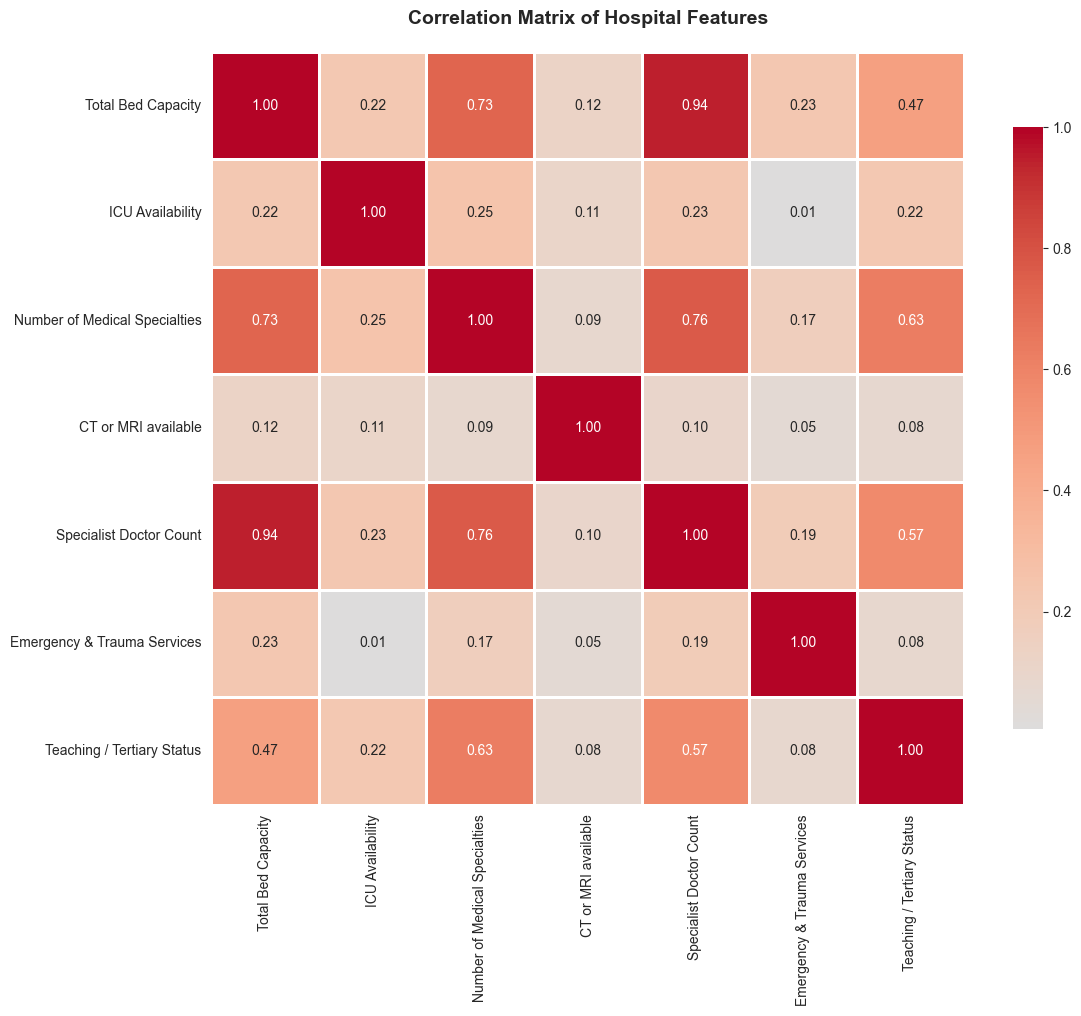

Saved: correlation_matrix.png


In [10]:
# Prepare data for correlation
df_numeric = df.copy()

# Select numeric columns
numeric_cols = [
    'Total Bed Capacity',
    'ICU Availability',
    'Number of Medical Specialties',
    'CT or MRI available',
    'Specialist Doctor Count',
    'Emergency & Trauma Services',
    'Teaching / Tertiary Status'
]

corr_matrix = df_numeric[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
           center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Hospital Features', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(EDA_PLOTS_DIR / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: correlation_matrix.png")


### 8.3 Teaching vs Non-Teaching Comparison


Teaching Hospitals: 145
  Avg Bed Capacity: 425.8
  Avg Specialties: 25.3
  Avg Specialists: 82.0

Non-Teaching Hospitals: 444
  Avg Bed Capacity: 207.3
  Avg Specialties: 13.4
  Avg Specialists: 28.0


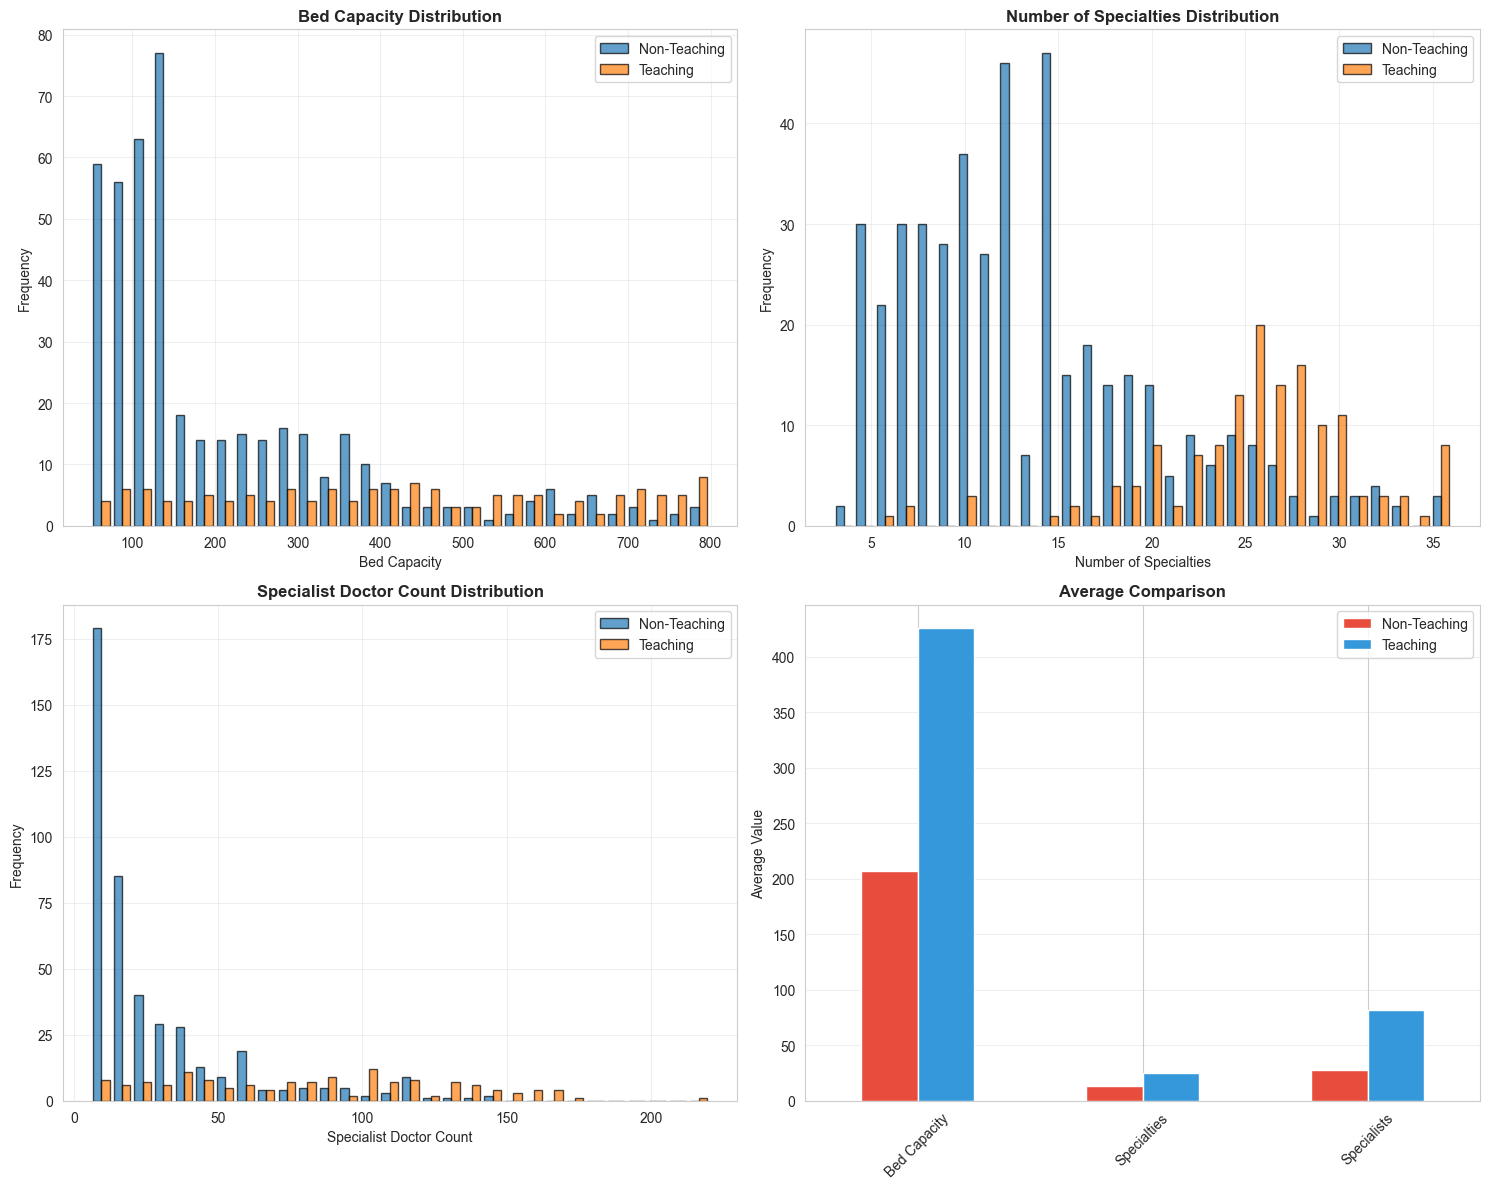

Saved: teaching_comparison.png


In [11]:
# Revert Teaching status to Yes/No for comparison
teaching = df[df['Teaching / Tertiary Status'] == 1]
non_teaching = df[df['Teaching / Tertiary Status'] == 0]

print(f"Teaching Hospitals: {len(teaching)}")
print(f"  Avg Bed Capacity: {teaching['Total Bed Capacity'].mean():.1f}")
print(f"  Avg Specialties: {teaching['Number of Medical Specialties'].mean():.1f}")
print(f"  Avg Specialists: {teaching['Specialist Doctor Count'].mean():.1f}")

print(f"\nNon-Teaching Hospitals: {len(non_teaching)}")
print(f"  Avg Bed Capacity: {non_teaching['Total Bed Capacity'].mean():.1f}")
print(f"  Avg Specialties: {non_teaching['Number of Medical Specialties'].mean():.1f}")
print(f"  Avg Specialists: {non_teaching['Specialist Doctor Count'].mean():.1f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Bed Capacity
axes[0, 0].hist([non_teaching['Total Bed Capacity'], teaching['Total Bed Capacity']], 
                bins=30, label=['Non-Teaching', 'Teaching'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Bed Capacity Distribution', fontweight='bold')
axes[0, 0].set_xlabel('Bed Capacity')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Number of Specialties
axes[0, 1].hist([non_teaching['Number of Medical Specialties'], 
                teaching['Number of Medical Specialties']], 
               bins=30, label=['Non-Teaching', 'Teaching'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Number of Specialties Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Number of Specialties')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Specialist Count
axes[1, 0].hist([non_teaching['Specialist Doctor Count'], 
                teaching['Specialist Doctor Count']], 
               bins=30, label=['Non-Teaching', 'Teaching'], alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Specialist Doctor Count Distribution', fontweight='bold')
axes[1, 0].set_xlabel('Specialist Doctor Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Comparison bar plot
comparison_data = pd.DataFrame({
    'Non-Teaching': [
        non_teaching['Total Bed Capacity'].mean(),
        non_teaching['Number of Medical Specialties'].mean(),
        non_teaching['Specialist Doctor Count'].mean()
    ],
    'Teaching': [
        teaching['Total Bed Capacity'].mean(),
        teaching['Number of Medical Specialties'].mean(),
        teaching['Specialist Doctor Count'].mean()
    ]
}, index=['Bed Capacity', 'Specialties', 'Specialists'])

comparison_data.plot(kind='bar', ax=axes[1, 1], color=['#e74c3c', '#3498db'])
axes[1, 1].set_title('Average Comparison', fontweight='bold')
axes[1, 1].set_ylabel('Average Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(EDA_PLOTS_DIR / 'teaching_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: teaching_comparison.png")


In [ ]:
# Split into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Split train_val into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, shuffle=True  
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Feature count: {X_train.shape[1]}")

print(f"\nTarget statistics:")
print(f"Train: mean={y_train.mean():.4f}, std={y_train.std():.4f}")
print(f"Val: mean={y_val.mean():.4f}, std={y_val.std():.4f}")
print(f"Test: mean={y_test.mean():.4f}, std={y_test.std():.4f}")


Training set: 353 samples
Validation set: 118 samples
Test set: 118 samples
Feature count: 14

Target statistics:
Train: mean=0.9658, std=0.2972
Val: mean=0.9101, std=0.3059
Test: mean=0.9733, std=0.3263


## Part 10: Save Processed Data


In [13]:
# Save as CSV
X_train.to_csv(DATA_OUTPUT_DIR / 'X_train.csv', index=False)
X_val.to_csv(DATA_OUTPUT_DIR / 'X_val.csv', index=False)
X_test.to_csv(DATA_OUTPUT_DIR / 'X_test.csv', index=False)
y_train.to_csv(DATA_OUTPUT_DIR / 'y_train.csv', index=False)
y_val.to_csv(DATA_OUTPUT_DIR / 'y_val.csv', index=False)
y_test.to_csv(DATA_OUTPUT_DIR / 'y_test.csv', index=False)

# Save as joblib for faster loading
joblib.dump(X_train, DATA_OUTPUT_DIR / 'X_train.joblib')
joblib.dump(X_val, DATA_OUTPUT_DIR / 'X_val.joblib')
joblib.dump(X_test, DATA_OUTPUT_DIR / 'X_test.joblib')
joblib.dump(y_train, DATA_OUTPUT_DIR / 'y_train.joblib')
joblib.dump(y_val, DATA_OUTPUT_DIR / 'y_val.joblib')
joblib.dump(y_test, DATA_OUTPUT_DIR / 'y_test.joblib')

# Save feature columns
joblib.dump(feature_columns, DATA_OUTPUT_DIR / 'feature_columns.joblib')

# Save processed dataframe
df.to_csv(DATA_OUTPUT_DIR / 'processed_data.csv', index=False)

print(f"All data saved to: {DATA_OUTPUT_DIR}")
print("\nFiles created:")
print("  - X_train.csv, X_val.csv, X_test.csv")
print("  - y_train.csv, y_val.csv, y_test.csv")
print("  - X_train.joblib, X_val.joblib, X_test.joblib")
print("  - y_train.joblib, y_val.joblib, y_test.joblib")
print("  - feature_columns.joblib")
print("  - processed_data.csv")


All data saved to: D:\Education and Works\Dreamware projects\Ambulance-Emergency\data-relay-system\backend\data

Files created:
  - X_train.csv, X_val.csv, X_test.csv
  - y_train.csv, y_val.csv, y_test.csv
  - X_train.joblib, X_val.joblib, X_test.joblib
  - y_train.joblib, y_val.joblib, y_test.joblib
  - feature_columns.joblib
  - processed_data.csv


## Part 11: Train Multiple ML Models


In [ ]:
# Initialize models with regularization to prevent overfitting
models = {
    'Linear Regression': LinearRegression(),  
    'Random Forest': RandomForestRegressor(
        n_estimators=100, 
        max_depth=8, 
        min_samples_split=10,  
        min_samples_leaf=4,  
        max_features='sqrt',  
        random_state=42, 
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100, 
        learning_rate=0.05, 
        max_depth=3, 
        min_samples_split=10,  
        min_samples_leaf=4, 
        subsample=0.8,  
        random_state=42
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100, 
        max_depth=3,  
        learning_rate=0.05,  
        subsample=0.7,  
        colsample_bytree=0.7,  
        reg_alpha=0.5,  
        reg_lambda=2.0, 
        min_child_weight=5,  
        random_state=42, 
        n_jobs=-1
    )
}

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    results[name] = {
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    trained_models[name] = model
    
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Val RMSE: {val_rmse:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Val R²: {val_r2:.4f}")
    print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Training Linear Regression...
Train RMSE: 0.1207
Val RMSE: 0.1240
Train R²: 0.8347
Val R²: 0.8343
CV R²: 0.8155 (+/- 0.0505)

Training Random Forest...
Train RMSE: 0.0831
Val RMSE: 0.1468
Train R²: 0.9216
Val R²: 0.7675
CV R²: 0.7825 (+/- 0.0719)

Training Gradient Boosting...
Train RMSE: 0.0244
Val RMSE: 0.1517
Train R²: 0.9932
Val R²: 0.7519
CV R²: 0.7607 (+/- 0.0434)

Training XGBoost...
Train RMSE: 0.0399
Val RMSE: 0.1495
Train R²: 0.9819
Val R²: 0.7590
CV R²: 0.7820 (+/- 0.0469)


## Part 11.5: Hyperparameter Tuning


In [ ]:
# Define hyperparameter grids for each model
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 8, 10],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [4, 6, 8],
        'max_features': ['sqrt', 'log2', 0.5]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4],
        'min_samples_split': [10, 15, 20],
        'min_samples_leaf': [4, 6, 8],
        'subsample': [0.7, 0.8, 0.9]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [2, 3, 4],
        'min_child_weight': [5, 7, 10],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'reg_alpha': [0.5, 1.0, 2.0],
        'reg_lambda': [2.0, 3.0, 5.0]
    }
}

tuned_models = {}
tuned_results = {}

print("Starting hyperparameter tuning...")
print("="*60)

# Skip Linear Regression as it has no hyperparameters
for name, model in models.items():
    if name == 'Linear Regression':
        continue  
    
    print(f"\n{'='*60}")
    print(f"Tuning {name}...")
    print('='*60)
    
    # Get parameter grid for this model
    param_grid = param_grids[name]
    
    # Create base model without parameters (will be set by GridSearchCV)
    if name == 'Random Forest':
        base_model = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif name == 'Gradient Boosting':
        base_model = GradientBoostingRegressor(random_state=42)
    elif name == 'XGBoost':
        base_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_tuned_model = grid_search.best_estimator_
    tuned_models[name] = best_tuned_model
    
    # Evaluate on validation set
    y_val_pred = best_tuned_model.predict(X_val)
    
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    # Cross-validation score on best model
    cv_scores = cross_val_score(
        best_tuned_model, X_train, y_train,
        cv=KFold(n_splits=5, shuffle=True, random_state=42),
        scoring='r2',
        n_jobs=-1
    )
    
    tuned_results[name] = {
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'val_rmse': val_rmse,
        'val_mae': val_mae,
        'val_r2': val_r2,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"\nBest Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nBest CV R²: {grid_search.best_score_:.4f}")
    print(f"Val RMSE: {val_rmse:.4f}")
    print(f"Val R²: {val_r2:.4f}")
    print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Add Linear Regression results (no tuning needed)
tuned_models['Linear Regression'] = models['Linear Regression']
tuned_results['Linear Regression'] = results['Linear Regression']

print("\n" + "="*60)
print("Hyperparameter tuning complete!")
print("="*60)


Starting hyperparameter tuning...

Tuning Random Forest...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Parameters:
  max_depth: 15
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 10
  n_estimators: 50

Best CV R²: 0.7781
Val RMSE: 0.1499
Val R²: 0.7579
CV R²: 0.7781 (+/- 0.0710)

Tuning Gradient Boosting...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters:
  learning_rate: 0.05
  max_depth: 3
  min_samples_leaf: 4
  min_samples_split: 10
  n_estimators: 100

Best CV R²: 0.7926
Val RMSE: 0.1409
Val R²: 0.7861
CV R²: 0.7926 (+/- 0.0719)

Tuning XGBoost...
Fitting 5 folds for each of 6561 candidates, totalling 32805 fits

Best Parameters:
  colsample_bytree: 0.7
  learning_rate: 0.05
  max_depth: 3
  min_child_weight: 3
  n_estimators: 150
  reg_alpha: 0.5
  reg_lambda: 3.0
  subsample: 0.9

Best CV R²: 0.8095
Val RMSE: 0.1398
Val R²: 0.7893
CV R²: 0.8095 (+/- 0.0613)

Hyperparameter tuning complete!


## Part 12: Model Comparison and Selection (Tuned vs Untuned)


In [16]:
# Create comparison dataframe
comparison_data = []
for name, metrics in results.items():
    comparison_data.append({
        'Model': name,
        'Train RMSE': metrics['train_rmse'],
        'Val RMSE': metrics['val_rmse'],
        'Train R²': metrics['train_r2'],
        'Val R²': metrics['val_r2'],
        'CV R² Mean': metrics['cv_mean'],
        'CV R² Std': metrics['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*60)
print("Model Comparison:")
print("="*60)
print(comparison_df.to_string(index=False))

# Select best model based on validation R²
best_model_name = comparison_df.loc[comparison_df['Val R²'].idxmax(), 'Model']
best_model = trained_models[best_model_name]

print(f"\n{'='*60}")
print(f"Best Model: {best_model_name}")
print(f"  Validation R²: {results[best_model_name]['val_r2']:.4f}")
print('='*60)



Model Comparison:
            Model  Train RMSE  Val RMSE  Train R²   Val R²  CV R² Mean  CV R² Std
Linear Regression    0.120666  0.123978  0.834696 0.834283    0.815529   0.025241
    Random Forest    0.083126  0.146840  0.921552 0.767529    0.782546   0.035963
Gradient Boosting    0.024393  0.151700  0.993245 0.751886    0.760677   0.021676
          XGBoost    0.039915  0.149512  0.981913 0.758992    0.782043   0.023452

Best Model: Linear Regression
  Validation R²: 0.8343


## Part 13: Feature Importance Analysis


In [17]:
# Get feature importance for tree-based models
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features ({best_model_name}):")
    print(feature_importance_df.head(10).to_string(index=False))
    
    # Visualize top features
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 15 Feature Importance ({best_model_name})', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(EDA_PLOTS_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: feature_importance.png")
    
    # Save feature importance
    feature_importance_df.to_csv(MODEL_DIR / 'feature_importance.csv', index=False)
    print(f"Saved feature importance CSV to: {MODEL_DIR / 'feature_importance.csv'}")
else:
    print(f"\n{best_model_name} does not provide feature importance")



Linear Regression does not provide feature importance


## Part 14: Evaluate Best Model on Test Set



Test Set Evaluation
Test RMSE: 0.1138
Test MAE: 0.0877
Test R²: 0.8772


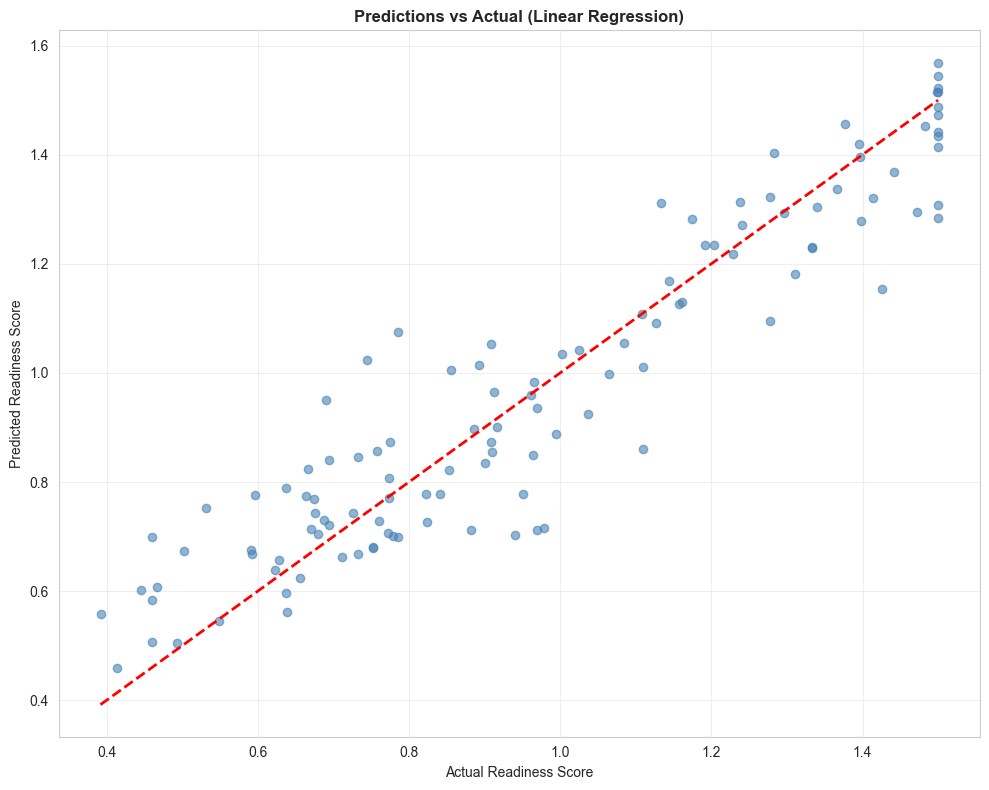

Saved: predictions_vs_actual.png


In [18]:
# Evaluate best model on test set
y_test_pred = best_model.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\n{'='*60}")
print("Test Set Evaluation")
print('='*60)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")
print('='*60)

# Plot predictions vs actual
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Readiness Score')
plt.ylabel('Predicted Readiness Score')
plt.title(f'Predictions vs Actual ({best_model_name})', fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(EDA_PLOTS_DIR / 'predictions_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: predictions_vs_actual.png")


## Part 15: Prediction Test


In [ ]:
# Define model paths (if not already defined from Part 15)
model_path = MODEL_DIR / 'hospital_evaluation_model.joblib'
metadata_path = MODEL_DIR / 'model_metadata.joblib'

# Load saved model and metadata for testing
loaded_model = joblib.load(model_path)
loaded_metadata = joblib.load(metadata_path)

# Get feature columns from metadata
feature_columns = loaded_metadata['feature_columns']

print(f"Loaded model: {loaded_metadata['model_name']}")
print(f"Model type: {loaded_metadata['model_type']}")
print(f"Test R²: {loaded_metadata['test_r2']:.4f}")
print(f"Loaded {len(feature_columns)} features")
print(f"Feature columns: {feature_columns}\n")

# Create sample hospital data for testing
test_hospitals = [
    {
        'name': 'Large Teaching Hospital',
        'Total Bed Capacity': 500,
        'ICU Availability': 'Yes',
        'Number of Medical Specialties': 30,
        'Key Specialty Presence': 'General, Cardiac, Cancer, Neuro, Multi-specialty',
        'CT or MRI available': 'Yes',
        'Specialist Doctor Count': 120,
        'Emergency & Trauma Services': 'Yes',
        'Teaching / Tertiary Status': 'Yes'
    },
    {
        'name': 'Medium Community Hospital',
        'Total Bed Capacity': 200,
        'ICU Availability': 'Yes',
        'Number of Medical Specialties': 15,
        'Key Specialty Presence': 'General, Cardiac',
        'CT or MRI available': 'Yes',
        'Specialist Doctor Count': 35,
        'Emergency & Trauma Services': 'Yes',
        'Teaching / Tertiary Status': 'No'
    },
    {
        'name': 'Small Rural Hospital',
        'Total Bed Capacity': 80,
        'ICU Availability': 'No',
        'Number of Medical Specialties': 8,
        'Key Specialty Presence': 'General',
        'CT or MRI available': 'No',
        'Specialist Doctor Count': 10,
        'Emergency & Trauma Services': 'Yes',
        'Teaching / Tertiary Status': 'No'
    },
    {
        'name': 'Specialized Cardiac Center',
        'Total Bed Capacity': 150,
        'ICU Availability': 'Yes',
        'Number of Medical Specialties': 12,
        'Key Specialty Presence': 'General, Cardiac',
        'CT or MRI available': 'Yes',
        'Specialist Doctor Count': 45,
        'Emergency & Trauma Services': 'Yes',
        'Teaching / Tertiary Status': 'Yes'
    },
    {
        'name': 'Large Non-Teaching Hospital',
        'Total Bed Capacity': 400,
        'ICU Availability': 'Yes',
        'Number of Medical Specialties': 25,
        'Key Specialty Presence': 'General, Cardiac, Cancer, Neuro',
        'CT or MRI available': 'Yes',
        'Specialist Doctor Count': 80,
        'Emergency & Trauma Services': 'Yes',
        'Teaching / Tertiary Status': 'No'
    }
]

# Convert to DataFrame
test_df = pd.DataFrame(test_hospitals)

print(f"{'='*60}")
print("Prediction Test - Sample Hospitals")
print('='*60)
print(f"\nTesting {len(test_hospitals)} sample hospitals...\n")

# Preprocess test data (same as training)
test_df_processed = test_df.copy()

# Encode categorical variables
binary_columns = [
    'ICU Availability',
    'CT or MRI available',
    'Emergency & Trauma Services',
    'Teaching / Tertiary Status'
]

for col in binary_columns:
    test_df_processed[col] = test_df_processed[col].map({'Yes': 1, 'No': 0})

all_specialties = ['Cardiac', 'Neuro', 'General', 'Multi-specialty', 'Cancer']
for specialty in all_specialties:
    col_name = f"Has_{specialty.replace(' ', '_')}"
    test_df_processed[col_name] = test_df_processed['Key Specialty Presence'].str.contains(specialty, case=False, na=False).astype(int)

# Feature engineering
test_df_processed['Bed_to_Doctor_Ratio'] = test_df_processed['Total Bed Capacity'] / (test_df_processed['Specialist Doctor Count'] + 1)
test_df_processed['Specialty_Density'] = test_df_processed['Number of Medical Specialties'] / (test_df_processed['Total Bed Capacity'] + 1)


# Ensure all features exist first
missing_features = []
for col in feature_columns:
    if col not in test_df_processed.columns:
        missing_features.append(col)
        test_df_processed[col] = 0
        print(f"Warning: Feature '{col}' not found in test data, filling with 0")

if missing_features:
    print(f"\nMissing features filled: {missing_features}")

# Select features in exact order and convert to numpy array to avoid feature name issues
X_test_samples = test_df_processed[feature_columns].values

# Debug: Print shape and first few values
print(f"\nX_test_samples shape: {X_test_samples.shape}")
print(f"Expected {len(feature_columns)} features")

# Make predictions
predictions = loaded_model.predict(X_test_samples)

# Display results
print(f"{'Hospital Name':<30} {'Predicted Readiness Score':<30} {'Category':<20}")
print('-' * 80)

for i, (idx, row) in enumerate(test_df.iterrows()):
    pred_score = predictions[i]
    
    # Categorize readiness
    if pred_score >= 1.2:
        category = "Excellent"
    elif pred_score >= 1.0:
        category = "Very Good"
    elif pred_score >= 0.8:
        category = "Good"
    elif pred_score >= 0.6:
        category = "Fair"
    else:
        category = "Needs Improvement"
    
    print(f"{row['name']:<30} {pred_score:>6.4f}                      {category:<20}")

print('-' * 80)
print(f"\n{'='*60}")
print("Prediction Test Complete!")
print('='*60)
print("\nModel successfully loaded and tested")
print("Predictions generated for all sample hospitals")
print("Model is ready for deployment")


Loaded model: Linear Regression
Model type: LinearRegression
Test R²: 0.8752
Loaded 14 features
Feature columns: ['Total Bed Capacity', 'ICU Availability', 'Number of Medical Specialties', 'CT or MRI available', 'Specialist Doctor Count', 'Emergency & Trauma Services', 'Teaching / Tertiary Status', 'Bed_to_Doctor_Ratio', 'Specialty_Density', 'Has_Multi-specialty', 'Has_Cardiac', 'Has_General', 'Has_Neuro', 'Has_Cancer']

Prediction Test - Sample Hospitals

Testing 5 sample hospitals...


X_test_samples shape: (5, 14)
Expected 14 features
Hospital Name                  Predicted Readiness Score      Category            
--------------------------------------------------------------------------------
Large Teaching Hospital        1.4720                      Excellent           
Medium Community Hospital      0.9947                      Good                
Small Rural Hospital           0.6173                      Fair                
Specialized Cardiac Center     1.1344               

## Part 16: Find Best Hospital


In [ ]:
# Load the original dataset to get full hospital information
df_original = pd.read_excel(DATA_PATH)

# Prepare all hospitals for prediction (same preprocessing as training)
df_all = df_original.copy()

# Encode categorical variables (convert in place, same as training)
binary_columns = [
    'ICU Availability',
    'CT or MRI available',
    'Emergency & Trauma Services',
    'Teaching / Tertiary Status'
]

for col in binary_columns:
    df_all[col] = df_all[col].map({'Yes': 1, 'No': 0})

# Parse specialty presence - create all specialty features that might exist
all_specialties = ['Cardiac', 'Neuro', 'General', 'Multi-specialty', 'Cancer']
for specialty in all_specialties:
    col_name = f"Has_{specialty.replace(' ', '_')}"
    df_all[col_name] = df_all['Key Specialty Presence'].str.contains(specialty, case=False, na=False).astype(int)

# Feature engineering
df_all['Bed_to_Doctor_Ratio'] = df_all['Total Bed Capacity'] / (df_all['Specialist Doctor Count'] + 1)
df_all['Specialty_Density'] = df_all['Number of Medical Specialties'] / (df_all['Total Bed Capacity'] + 1)


# Ensure all features exist first
missing_features = []
for col in feature_columns:
    if col not in df_all.columns:
        missing_features.append(col)
        df_all[col] = 0
        print(f"Warning: Feature '{col}' not found in data, filling with 0")

if missing_features:
    print(f"\nMissing features filled: {missing_features}")

# Select features in exact order and convert to numpy array to avoid feature name issues
X_all = df_all[feature_columns].values

# Make predictions for all hospitals
all_predictions = loaded_model.predict(X_all)

# Add predictions to dataframe
df_all['Predicted_Readiness_Score'] = all_predictions

# Find the best hospital (highest predicted readiness score)
best_hospital_idx = df_all['Predicted_Readiness_Score'].idxmax()
best_hospital = df_all.loc[best_hospital_idx]

print(f"{'='*60}")
print("Best Hospital Analysis")
print('='*60)
print(f"\nBest Hospital: {best_hospital['Hospital Name']}")
print(f"Predicted Readiness Score: {best_hospital['Predicted_Readiness_Score']:.4f}")

print(f"\n{'='*60}")
print("Hospital Details:")
print('='*60)
print(f"  Total Bed Capacity: {best_hospital['Total Bed Capacity']}")
print(f"  ICU Availability: {'Yes' if best_hospital['ICU Availability'] == 1 else 'No'}")
print(f"  Number of Medical Specialties: {best_hospital['Number of Medical Specialties']}")
print(f"  Key Specialty Presence: {best_hospital['Key Specialty Presence']}")
print(f"  CT or MRI available: {'Yes' if best_hospital['CT or MRI available'] == 1 else 'No'}")
print(f"  Specialist Doctor Count: {best_hospital['Specialist Doctor Count']}")
print(f"  Emergency & Trauma Services: {'Yes' if best_hospital['Emergency & Trauma Services'] == 1 else 'No'}")
print(f"  Teaching / Tertiary Status: {'Yes' if best_hospital['Teaching / Tertiary Status'] == 1 else 'No'}")

if 'Readiness Score' in df_original.columns:
    actual_score = df_original.loc[best_hospital_idx, 'Readiness Score']
    print(f"  Actual Readiness Score (from dataset): {actual_score:.4f}")
    print(f"  Prediction Error: {abs(best_hospital['Predicted_Readiness_Score'] - actual_score):.4f}")

print(f"\n{'='*60}")
print("Top 10 Hospitals by Predicted Readiness Score:")
print('='*60)

# Get top 10 hospitals
top_10 = df_all.nlargest(10, 'Predicted_Readiness_Score')[['Hospital Name', 'Predicted_Readiness_Score']]
print(f"\n{'Rank':<6} {'Hospital Name':<50} {'Score':<10}")
print('-' * 70)
for idx, (i, row) in enumerate(top_10.iterrows(), 1):
    print(f"{idx:<6} {row['Hospital Name']:<50} {row['Predicted_Readiness_Score']:.4f}")

print(f"\n{'='*60}")
print("Best Hospital Analysis Complete")
print('='*60)


Best Hospital Analysis

Best Hospital: Nuwara Eliya Base Healthcare Center
Predicted Readiness Score: 1.6133

Hospital Details:
  Total Bed Capacity: 758
  ICU Availability: Yes
  Number of Medical Specialties: 35
  Key Specialty Presence: Cancer, Cardiac, General, Multi-specialty, Neuro
  CT or MRI available: Yes
  Specialist Doctor Count: 143
  Emergency & Trauma Services: Yes
  Teaching / Tertiary Status: Yes
  Actual Readiness Score (from dataset): 1.5000
  Prediction Error: 0.1133

Top 10 Hospitals by Predicted Readiness Score:

Rank   Hospital Name                                      Score     
----------------------------------------------------------------------
1      Nuwara Eliya Base Healthcare Center                1.6133
2      District Hospital Kandy                            1.6004
3      Colombo North Teaching Hospital                    1.5790
4      Sri Piliyandala Healthcare Center                  1.5769
5      Sri Hambantota General Hospital                    1.

In [21]:
# Save best model
model_path = MODEL_DIR / 'hospital_evaluation_model.joblib'
joblib.dump(best_model, model_path)
print(f"Saved model: {model_path}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': type(best_model).__name__,
    'test_rmse': test_rmse,
    'test_mae': test_mae,
    'test_r2': test_r2,
    'val_r2': results[best_model_name]['val_r2'],
    'feature_columns': feature_columns
}

metadata_path = MODEL_DIR / 'model_metadata.joblib'
joblib.dump(metadata, metadata_path)
print(f"Saved metadata: {metadata_path}")

print(f"\n{'='*60}")
print("Model Training Complete")
print('='*60)


Saved model: D:\Education and Works\Dreamware projects\Ambulance-Emergency\data-relay-system\backend\models\hospital_evaluation_model.joblib
Saved metadata: D:\Education and Works\Dreamware projects\Ambulance-Emergency\data-relay-system\backend\models\model_metadata.joblib

Model Training Complete
